In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow_text
import spacy
import numpy
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("../Datasets/Stem-Cuvinte-Eliminate/train-punct-stop-stem-200.csv",)
df=df.sample(n=50000)
#df=df.drop(["Unnamed: 0"],axis=1)


In [3]:
df.head()
df=df.dropna()
df.count()

sentiment    49999
text         49999
dtype: int64

In [4]:
texts=df["text"]
nlp = spacy.load("en_core_web_sm")

In [5]:
print(texts)

1704237    instal 2 one garag door one side chain track t...
3162879    book hilari make lot good point wouldnt take t...
1222406    great watch give accur time everi day look goo...
2630879    song not origin record redon origin artist not...
1166518    typic sog qualiti even made china china type b...
                                 ...                        
953721     love bird eat gray sunflow seed realli noth el...
1067568    id realli say one best book ive read long time...
2709724    book horribl teacher make read analyz im 13 ac...
1760186    got wife xma realli nice unit start drawback s...
371200     comfort cushion better one purchas walgreen ev...
Name: text, Length: 49999, dtype: object


In [6]:
tokenized_texts=[]
for text in texts:
    doc=nlp(text)
    filtered_tokens = [token for token in doc]
    tokenized_texts.append(filtered_tokens)

In [7]:
tokenized_texts

[[instal,
  2,
  one,
  garag,
  door,
  one,
  side,
  chain,
  track,
  took,
  hour,
  i,
  m,
  happi,
  abl,
  use,
  addit,
  bracket,
  secur,
  strong,
  angl,
  iron,
  brace,
  use,
  hold,
  garag,
  motor,
  good,
  product,
  design,
  flimsi,
  without,
  addit,
  bracket],
 [book,
  hilari,
  make,
  lot,
  good,
  point,
  would,
  nt,
  take,
  tip,
  rule,
  heart,
  write,
  style,
  deliv,
  blackandwhit,
  philosophi,
  guis,
  fact,
  still,
  enjoy,
  read,
  comed,
  valu],
 [great,
  watch,
  give,
  accur,
  time,
  everi,
  day,
  look,
  good,
  function,
  flawlessli,
  year,
  sometim,
  dirti,
  sweati,
  physic,
  environ,
  devil,
  look,
  brand,
  new,
  crystal,
  has,
  nt,
  scratch,
  light,
  soap,
  water,
  rins,
  i,
  m,
  readi,
  dinner,
  better,
  half,
  term,
  appear,
  perform,
  watch,
  great,
  valu,
  omega,
  purchas,
  1967,
  ye,
  i,
  m,
  old,
  still,
  work,
  perfectli,
  i,
  m,
  save,
  grandkid,
  differ,
  crystal,
 

In [8]:
max=0
for text in tokenized_texts:
    if len(text)>max:
        max=len(text)
print(max)

126


In [9]:
max=128
expanded_tokenized_texts=[]
for text in tokenized_texts:
    text=text[:max] + [nlp("null")]*(max - len(text))
    expanded_tokenized_texts.append(text)

In [10]:
normalized_texts=[]
for text in  expanded_tokenized_texts:
    vectors=[]
    for word in text:
        vectors.append((numpy.array(word.vector)))
    normalized_texts.append(numpy.array(vectors))

In [11]:
print(numpy.array(normalized_texts).shape)

#df=df.drop(["Un

(49999, 128, 96)


In [12]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  df.sentiment.to_numpy().reshape(-1, 1)
)

In [13]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
train_news, test_news, y_train, y_test =\
  train_test_split(
    normalized_texts, 
    type_one_hot, 
    test_size=.1, 
    random_state=RANDOM_SEED
  )

In [14]:
train_news=np.array(train_news)
test_news=np.array(test_news)
y_train=np.array(y_train)
y_test=np.array(y_test)


In [15]:
print(train_news[1].shape)
print(test_news.shape)
print(y_train.shape)
print(y_test.shape)

(128, 96)
(5000, 128, 96)
(44999, 2)
(5000, 2)


In [16]:
print(train_news.shape)

(44999, 128, 96)


In [17]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=128,
    input_shape=(train_news[1].shape[0],train_news[1].shape[1]),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.GlobalMaxPool1D())

model.add(
  keras.layers.Dense(
    units=32,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

2022-02-18 20:45:25.943716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 20:45:26.625513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 20:45:26.626759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 20:45:26.629419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 128)          12416     
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6

In [25]:
history = model.fit(
    train_news, y_train, 
    epochs=4, 
    batch_size=16, 
    validation_split=0.1,
    verbose=1, 
    shuffle=True
)

2022-02-18 20:56:49.950537: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.85GiB (rounded to 1990606848)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-18 20:56:49.950604: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-02-18 20:56:49.950639: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 41, Chunks in use: 40. 10.2KiB allocated for chunks. 10.0KiB in use in bin. 1.3KiB client-requested in use in bin.
2022-02-18 20:56:49.950661: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 4, Chunks in use: 3. 2.0KiB allocated for chunks. 1.5KiB in use in bin. 1.5KiB client-requested in use in bin.
2022-02-18 20:56:49.950681: I t

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

(Text(0, 0.5, 'Cross-entropy loss'),)

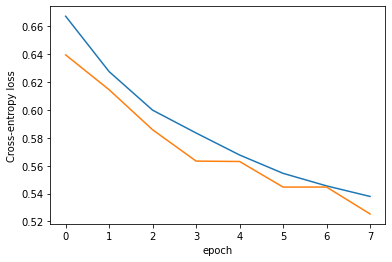

In [20]:
plt.plot(history.history['loss'], label='train loss'),
plt.plot(history.history['val_loss'], label='val loss'),
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss"),

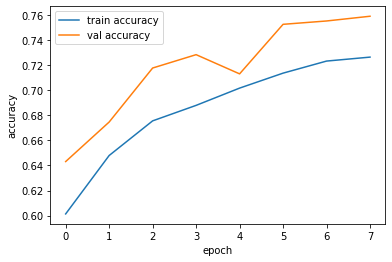

In [21]:
    plt.plot(history.history['accuracy'], label='train accuracy'),
    plt.plot(history.history['val_accuracy'], label='val accuracy'),
    plt.xlabel("epoch"),
    plt.ylabel("accuracy"),
    plt.legend();

In [22]:
model.evaluate(test_news, y_test)

  1/157 [..............................] - ETA: 2s - loss: 0.4524 - accuracy: 0.8750

2022-02-18 20:46:18.493635: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.
2022-02-18 20:46:18.678053: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.


157/157 [==============================] - 0s 2ms/step - loss: 0.5333 - accuracy: 0.7490


[0.5333201289176941, 0.7490000128746033]

In [23]:
model.save('./Model-200-Dense/')

2022-02-18 20:46:19.518675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Model-200-Dense/assets
